In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
project_names = [
    "gender_female",
    "gender_male",
    #    "language_de",
    #    "language_en",
    #    "language_es",
    #    "language_fr",
    #    "language_it",
    #    "language_ja",
    #    "language_pt",
]
encoder_ids = [
    "mert_v1_95m",
    "whisper_large_v2",
    "muq_large_msd",
    "muq_mulan_large",
]
target_column = "genre"

In [3]:
import itertools
import os
import IPython.display as ipd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from cavmir.evaluation import calculate_tcav_score
from cavmir.utils import load_df_and_embeddings
from typing import Literal

s3 = s3fs.S3FileSystem()

trainings_prefix = os.environ["TRAININGS_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]
audio_prefix = os.environ["AUDIO_PREFIX"]


In [5]:
def get_cav_vectors(
    project_name, encoder_id, train_type: Literal["ttest", "full"] = "ttest"
):
    cav_vector_dir = os.path.join(
        trainings_prefix,
        "trainings",
        encoder_id,
        project_name,
        f"cav_{train_type}_{project_name}.npy",
    )
    cav_vector = np.load(cav_vector_dir)
    return cav_vector


def get_train_evaluation_metrics(
    project_name, encoder_id, train_type: Literal["ttest", "full"] = "full"
):
    metrics_dir = os.path.join(
        trainings_prefix,
        "trainings",
        encoder_id,
        project_name,
        f"evaluation_metrics_{train_type}_{project_name}.json",
    )
    metrics = json.load(open(metrics_dir))
    return metrics

### Use Case 1: Sort Audio Samples by CAV vector


In [5]:
import umap


def sort_ids_by_dot_product(df, cav_vector):
    ids = df["song_id"].values
    embeddings = np.array([np.array(x) for x in df.embedding.values])

    targets = df["target"].values

    dot_products = np.dot(embeddings, np.atleast_2d(cav_vector).T)

    sorted_ids = [id for _, id in sorted(zip(dot_products, ids), reverse=True)]
    sorted_targets = [
        target for _, target in sorted(zip(dot_products, targets), reverse=True)
    ]

    return sorted_ids, dot_products, sorted_targets


def get_song_by_id(song_id):
    uri = f"{audio_prefix}{song_id}.mp3"
    ipd.display(ipd.Audio(s3.cat(uri)))


def umap_plot(df, cav_vector, title):
    embeddings = np.array([np.array(x) for x in df.embedding.values])
    labels = df["target"].values

    reducer = umap.UMAP()
    reduced_embeddings = reducer.fit_transform(embeddings)
    reduced_cav_vector = reducer.transform(np.atleast_2d(cav_vector))

    print(reduced_cav_vector)

    plt.figure(figsize=(10, 10))
    plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=dot_products,
        cmap="viridis",
        s=5,
        alpha=0.5,
    )

    # draw cav vector as decision boundary
    plt.plot(
        [reduced_cav_vector[0, 0], 0],
        [reduced_cav_vector[0, 1], 0],
        color="red",
        linewidth=2,
    )

    plt.colorbar()
    plt.title(title)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
# from umap.parametric_umap import ParametricUMAP


def plot_umap_with_decision_boundary(
    activations,
    cav,
    labels,
    umap_model=None,
    n_directions=10,
    n_steps=20,
    span=1.0,
    random_state=42,
):
    """
    Plot UMAP with nonlinear projection of the CAV decision boundary.

    Parameters:
        activations: [n_samples, n_features]
        cav: Concept Activation Vector [n_features]
        labels: True labels
        umap_model: Optional pre-fit UMAP model
        n_directions: Number of orthogonal directions in the boundary plane
        n_steps: Number of interpolation steps along each direction
        span: How far to step out along each direction
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import umap

    rng = np.random.default_rng(seed=random_state)

    # Fit UMAP if needed
    if umap_model is None:
        umap_model = umap.UMAP(
            n_neighbors=200,
            min_dist=0.1,
            metric="cosine",  # random_state=random_state
        )
        umap_2d = umap_model.fit_transform(activations)
    else:
        umap_2d = umap_model.transform(activations)

    # Normalize CAV
    cav = cav / np.linalg.norm(cav)

    # Find a base point on the decision boundary
    relevance = activations @ cav
    x0 = activations[np.argmin(np.abs(relevance))]  # Closest to boundary

    # Create multiple orthogonal directions
    orth_vectors = []
    for _ in range(n_directions):
        rand = rng.normal(size=cav.shape)
        ortho = rand - cav * (rand @ cav)
        ortho /= np.linalg.norm(ortho)
        orth_vectors.append(ortho)

    # Sample points along each direction, centered at x0
    boundary_points = []
    for v in orth_vectors:
        for t in np.linspace(-span, span, n_steps):
            boundary_points.append(x0 + t * v)

    boundary_points = np.stack(boundary_points)

    mask = np.abs(relevance) < 0.05
    boundary_activations = activations[mask]
    boundary_umap = umap_model.transform(boundary_activations)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=umap_2d[:, 0], y=umap_2d[:, 1], hue=labels, palette="coolwarm", alpha=0.6
    )
    plt.plot(
        boundary_umap[:, 0],
        boundary_umap[:, 1],
        "k.",
        markersize=2,
        label="CAV Decision Boundary",
    )
    plt.title("UMAP with CAV Decision Boundary (Nonlinear Projection)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def visualize_cav_concept(activations, cav, labels, figsize=(18, 5), random_state=42):
    """
    Visualize a CAV using:
    1. Custom projection along the CAV
    2. UMAP colored by CAV relevance
    3. Relevance histogram per label

    Parameters:
    - activations: np.array [n_samples, n_features]
    - cav: np.array [n_features]
    - labels: array-like [n_samples,] (any number of discrete labels)
    """

    # Normalize CAV and compute relevance scores
    cav = cav / np.linalg.norm(cav)
    relevance = activations @ cav
    labels = np.array(labels)

    # Determine color range: symmetric around 0
    abs_max = np.max(np.abs(relevance))
    hue_norm = (-abs_max, abs_max)

    # Unique labels for multi-label support
    unique_labels = np.unique(labels)
    markers = ["o", "X", "s", "D", "^", "v", "*", "P", "H"]  # add more if needed
    label_marker_map = {
        label: markers[i % len(markers)] for i, label in enumerate(unique_labels)
    }

    # === Custom projection: CAV + orthogonal ===
    proj_cav = relevance
    random_vec = np.random.randn(*cav.shape)
    orth_vec = random_vec - cav * (random_vec @ cav)
    orth_vec /= np.linalg.norm(orth_vec)
    proj_orth = activations @ orth_vec
    custom_2d = np.stack([proj_cav, proj_orth], axis=1)

    # === UMAP projection ===
    umap_model = umap.UMAP(
        n_neighbors=200,
        min_dist=0.1,
        metric="cosine",
        target_metric="l2",  # use label space distance
        target_weight=0.5,  # balance feature vs. target
    ).fit(activations)  # , y=relevance)
    umap_2d = umap_model.fit_transform(activations)  # , y=relevance)

    # === Plotting ===
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # --- Custom projection plot ---
    ax = axes[0]
    for label in unique_labels:
        mask = labels == label
        sns.scatterplot(
            x=custom_2d[mask, 0],
            y=custom_2d[mask, 1],
            hue=relevance[mask],
            palette="coolwarm",
            hue_norm=hue_norm,
            marker=label_marker_map[label],
            alpha=0.7,
            ax=ax,
            legend=False,
            label=f"Label {label}",
        )
    ax.axvline(0, color="black", linestyle="--", label="CAV Decision Boundary")
    ax.set_title("Custom Projection (CAV Axis)")
    ax.set_xlabel("Projection onto CAV")
    ax.set_ylabel("Orthogonal Direction")
    ax.grid(True)

    # --- UMAP plot ---
    ax = axes[1]
    for label in unique_labels:
        mask = labels == label
        sns.scatterplot(
            x=umap_2d[mask, 0],
            y=umap_2d[mask, 1],
            hue=relevance[mask],
            palette="coolwarm",
            hue_norm=hue_norm,
            marker=label_marker_map[label],
            alpha=0.7,
            ax=ax,
            legend=False,
            label=f"Label {label}",
        )

    mask = np.abs(relevance) < 0.05
    boundary_activations = activations[mask]
    boundary_umap = umap_model.transform(boundary_activations)

    ax.plot(
        boundary_umap[:, 0],
        boundary_umap[:, 1],
        "k.",
        markersize=2,
        label="CAV Decision Boundary",
    )
    ax.set_title("UMAP (CAV Relevance)")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.grid(True)

    # --- Histogram of relevance ---
    ax = axes[2]
    for label in unique_labels:
        sns.histplot(
            relevance[labels == label],
            label=f"Label {label}",
            kde=True,
            bins=50,
            ax=ax,
            alpha=0.6,
        )
    ax.axvline(0, color="black", linestyle="--", label="CAV Decision Boundary")
    ax.set_title("Histogram of CAV Relevance by Label")
    ax.set_xlabel("Relevance (Dot Product with CAV)")
    ax.set_ylabel("Count")
    ax.grid(True)

    # --- Finalize ---
    fig.suptitle("CAV Visualization: Relevance, Labels, and Projections", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    ax.legend()
    plt.show()


Evaluating gender_female mert_v1_95m genre


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Gener

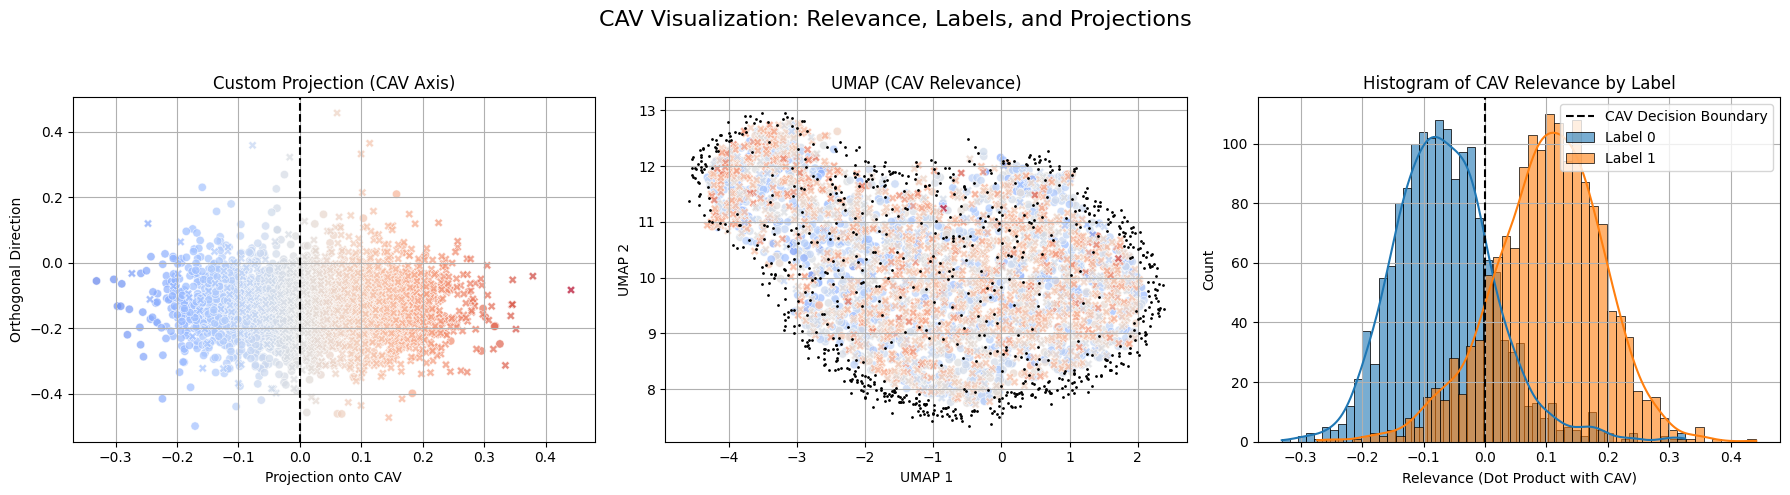

Evaluating gender_female whisper_large_v2 genre


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
find

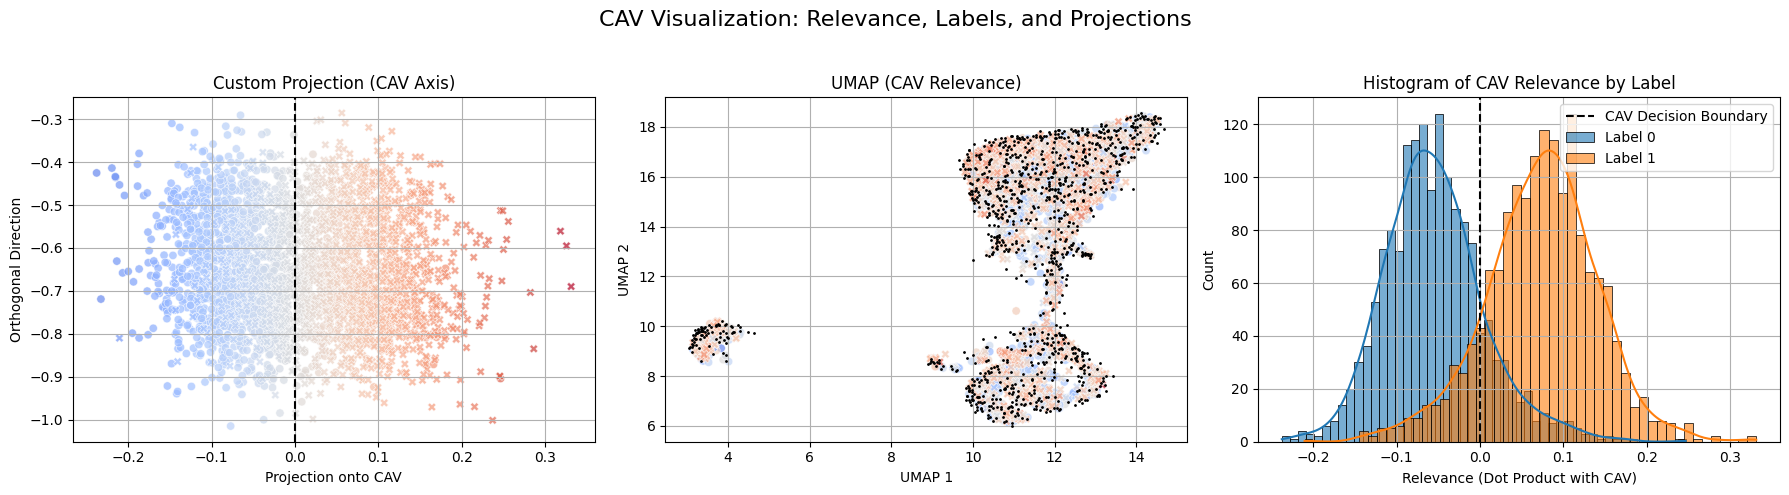

Evaluating gender_female muq_large_msd genre


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
find

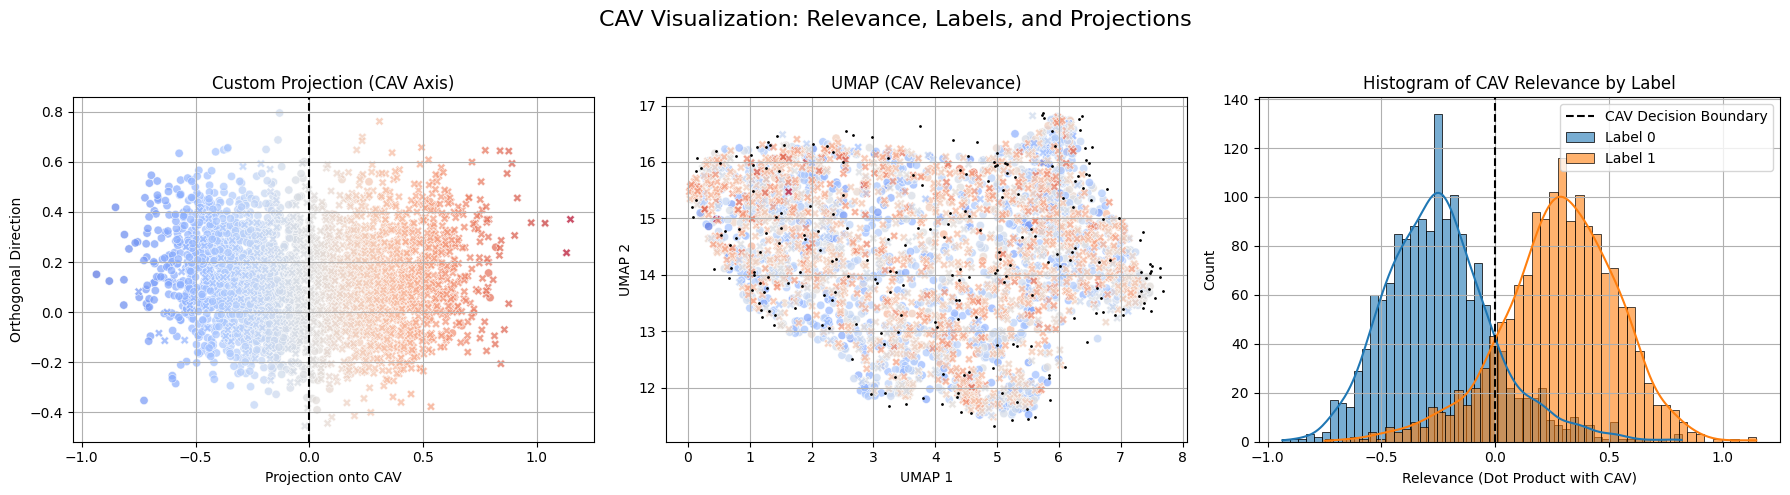

/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating gender_female muq_mulan_large genre


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Ge

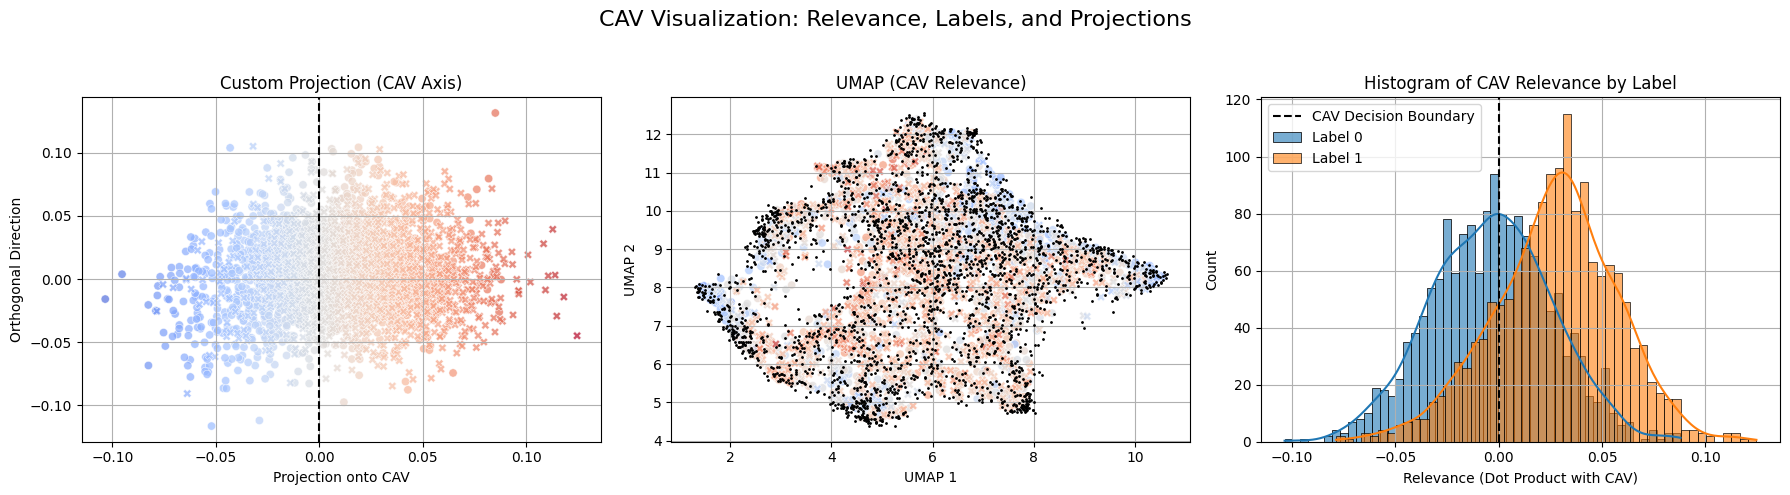

In [10]:
evaluation_variations = [*itertools.product(project_names, encoder_ids)]

for project_name, encoder_id in evaluation_variations:
    print(f"Evaluating {project_name} {encoder_id} {target_column}")
    df_test = load_df_and_embeddings(
        project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
    )

    cav_vector = get_cav_vectors(project_name, encoder_id, "full")[0]

    embeddings = np.array([np.array(x) for x in df_test.embedding.values])
    labels = df_test["target"].values

    # plot_umap_with_decision_boundary(embeddings, cav_vector, labels, random_state=0)

    visualize_cav_concept(
        embeddings, cav_vector, labels, figsize=(18, 5), random_state=0
    )


### Use Case 2: Measuring Model Bias Using TCAV


In [ ]:
from collections import defaultdict
import json
from typing import Literal
from matplotlib import gridspec
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.stats import ttest_1samp

plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["FreeSans"],
        "font.serif": ["FreeSerif"],
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        # "text.usetex": True,
    }
)


def calculate_tcav_scores(
    cav_vectors: np.ndarray,
    cav_biases: np.ndarray,
    df: pd.DataFrame,
    target_column: str,
    embedding_prefix: str,
    encoder_id: str,
) -> dict[str, list[float]]:
    """
    Calculates the TCAV scores for each target label in the dataset.

    """
    target_labels = df[target_column].unique()

    tcav_scores = defaultdict(list)
    for target_label in target_labels:
        df_subset = df[df[target_column] == target_label]
        target_embeddings = np.array([np.array(x) for x in df_subset.embedding.values])
        for i, cav_vector in enumerate(cav_vectors):
            tcav_scores[target_label].append(
                calculate_tcav_score(cav_vector, target_embeddings, cav_biases[i])
            )

    return tcav_scores


def t_test_on_tcav_scores(
    tcav_scores: dict[str, list[float]],
    target_p_value: float = 0.05,
    bonferroni_correction: bool = True,
    verbose: bool = True,
) -> dict[str, dict[str, float | list[float] | bool]]:
    """
    Performs a t-test on the TCAV scores of each trained cav vector per target label.
    The null hypothesis is that the TCAV scores do not diverge from 0.5 (no bias).

    Parameters
    ----------
    tcav_scores : dict[str, list[float]]
        The TCAV scores per target label. Since we train mulitple cav vectors per target label, we expect a list of scores.
    target_p_value : float, optional
        The p-value threshold for the t-test, by default 0.05
    bonferroni_correction : bool, optional
        Whether to perform the Bonferroni correction on the p-values, by default True

    Returns
    -------
    pvalues : list[float]
        The p-values of the t-test for each target label.
    target_p_value : float
        The target p-value used for the t-test.
    """

    if bonferroni_correction:
        target_p_value_str = (
            f"({target_p_value} / {len(tcav_scores)}) (Bonferroni corrected)"
        )
        target_p_value = target_p_value / len(tcav_scores)
    else:
        target_p_value_str = f"{target_p_value}"

    results = defaultdict(dict)
    for label, scores in tcav_scores.items():
        ttest_result = ttest_1samp(scores, 0.5)

        p_value = ttest_result.pvalue
        statistic = ttest_result.statistic

        results[label]["t_statistic"] = statistic.tolist()
        results[label]["p_value"] = p_value.tolist()
        results[label]["confidence_interval"] = [
            *ttest_result.confidence_interval(confidence_level=1 - target_p_value)
        ]
        results[label]["significant"] = p_value < target_p_value

        if not verbose:
            continue

        print(
            f"\nPerforming t-test on TCAV scores for label: {label}\nt-statistic: {statistic:.4f}"
        )

        if p_value < target_p_value:
            print(f"p-value: {p_value:.4e} < {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) can be rejected.")
        else:
            print(f"p-value: {p_value:.4e} >= {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) cannot be rejected.")

    return results


project_name_display_map = {
    "gender_female": "Sex - Female",
    "gender_male": "Sex - Male",
    "language_de": "Language - German",
    "language_en": "Language - English",
    "language_es": "Language - Spanish",
    "language_fr": "Language - French",
    "language_it": "Language - Italian",
    "language_ja": "Language - Japanese",
    "language_pt": "Language - Portuguese",
    "r&b": "R\\&B",
}


def plot_tcav_scores(
    results: dict,
    project_name: str,
    out_file_name: str | None = None,
    ci_boxplot: bool = False,
):
    """
    Creates a relative bar plot of the TCAV scores for each target label.
    """

    def humaize_label(label):
        if label in project_name_display_map:
            return project_name_display_map[label]

        label = label.replace("_", " ")
        label = " ".join([x.capitalize() for x in label.split(" ")])
        return label

    colors = {
        "neutral": "#90A4AE",
        "positive": "#AED581",
        "negative": "#FF8A65",
    }

    encoders = [*results.keys()]
    n_encoders = len(results)

    sorted_labels = [
        *dict(
            sorted(
                results[encoders[0]]["tcav_scores"].items(),
                key=lambda x: np.mean(x[1]),
                reverse=False,
            )
        ).keys()
    ]

    fig = plt.figure(figsize=(18, 4))
    gs = gridspec.GridSpec(1, n_encoders, width_ratios=[1, 1, 1, 1], wspace=0)

    axes = [fig.add_subplot(gs[i]) for i in range(n_encoders)]

    for i, (encoder, ax) in enumerate(zip(encoders, axes)):
        sorted_data = [
            results[encoder]["tcav_scores"][label] for label in sorted_labels
        ]

        box_colors = [
            colors["neutral"]
            if not results[encoder]["ttest_results"][label]["significant"]
            else colors["positive"]
            if np.mean(scores) > 0.5
            else colors["negative"]
            for label, scores in zip(sorted_labels, sorted_data)
        ]

        if ci_boxplot:
            stats = []
            for label in sorted_labels:
                scores = results[encoder]["tcav_scores"][label]
                ci = results[encoder]["ttest_results"][label]["confidence_interval"]
                median = np.median(scores)
                mean = np.mean(scores)

                stats.append(
                    {
                        "label": label,
                        "med": median,
                        "mean": mean,
                        "q1": ci[0],
                        "q3": ci[1],
                        "whislo": ci[0],
                        "whishi": ci[1],
                        "fliers": scores,
                    }
                )

            bplot = ax.bxp(
                stats,
                orientation="horizontal",
                showmeans=True,
                meanprops=dict(
                    marker="D",
                    markeredgecolor="black",
                    markerfacecolor="firebrick",
                    markersize=2,
                    alpha=0.0,
                ),
                boxprops=dict(linewidth=0.5, alpha=1, zorder=3),
                whiskerprops=dict(linewidth=0.5, alpha=0),
                capprops=dict(linewidth=0.5, alpha=0),
                medianprops=dict(linewidth=1.0, color="firebrick", zorder=4),
                flierprops=dict(
                    marker="o", color="black", alpha=0.01, markersize=2, zorder=1
                ),
                patch_artist=True,
            )

        else:
            bplot = ax.boxplot(
                sorted_data,
                vert=False,
                patch_artist=True,
                boxprops=dict(linewidth=0.5),
                flierprops=dict(marker="o", color="gray", alpha=0.5, markersize=3),
                whiskerprops=dict(linewidth=0.5),
                capprops=dict(linewidth=0.5),
                medianprops=dict(linewidth=1.5, color="firebrick"),
                meanprops=dict(
                    marker="D",
                    markeredgecolor="black",
                    markerfacecolor="firebrick",
                    markersize=3,
                ),
                showmeans=True,
            )

        for patch, color in zip(bplot["boxes"], box_colors):
            patch.set_facecolor(color)

        ax.axvline(0.5, color="black", linewidth=0.5)

        if i == 0:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([humaize_label(x) for x in sorted_labels])
        else:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([])

        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(-0.05, 1.05)

        ax.grid(axis="x", linestyle="--", linewidth=0.5)

        if i == n_encoders - 1:

            class MultiColorLegend:
                def __init__(self, colors):
                    self._colors = colors

            # Custom legend handler
            class MultiColorPatchHandler(HandlerBase):
                def create_artists(
                    self,
                    legend,
                    orig_handle,
                    xdescent,
                    ydescent,
                    width,
                    height,
                    fontsize,
                    trans,
                ):
                    patches = []
                    n = len(orig_handle._colors)
                    for i, color in enumerate(orig_handle._colors):
                        p = Rectangle(
                            (xdescent + i * width / n, ydescent),
                            width / n,
                            height,
                            facecolor=color,
                            edgecolor="black",
                            transform=trans,
                            linewidth=0.3,
                        )
                        patches.append(p)
                    return patches

            # Create dummy legend object
            combined_bias = MultiColorLegend(
                [colors["positive"], colors["negative"], colors["neutral"]]
            )

            # Add to legend
            legend_elements = [
                combined_bias,
                Line2D(
                    [0],
                    [0],
                    marker="|",
                    linestyle="None",
                    color="firebrick",
                    markersize=12,
                    markeredgewidth=2,
                    label="Median",
                ),
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    linestyle="None",
                    color="gray",
                    alpha=0.5,
                    markersize=4,
                    label="Individual sample",
                ),
            ]

            plt.legend(
                handles=legend_elements,
                labels=["95\\% CI", "Median", "TCAV sample"],
                handler_map={MultiColorLegend: MultiColorPatchHandler()},
                loc="lower right",
                fontsize="x-small",
            )

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        test_acc = results[encoder]["metrics_ttest_mean_acc"]
        ax.set_title(
            f"Encoder: {encoder} (Ø Test Acc: {test_acc:.2f})",
            fontsize=12,
            pad=10,
            loc="left",
        )

    # fig.suptitle(
    #    rf"Bias Evaluation for Concept: \textit{{{humaize_label(project_name)}}}",
    #    fontsize=16,
    #    y=1.05,
    # )

    fig.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.05, left=0.05, right=0.98, wspace=0)

    if out_file_name:
        fig.savefig(out_file_name, dpi=300, bbox_inches="tight")

    plt.show()


Evaluating gender_female with mert_v1_95m on genre


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Evaluating gender_female with whisper_large_v2 on genre


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Evaluating gender_female with muq_large_msd on genre


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Evaluating gender_female with muq_mulan_large on genre


findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

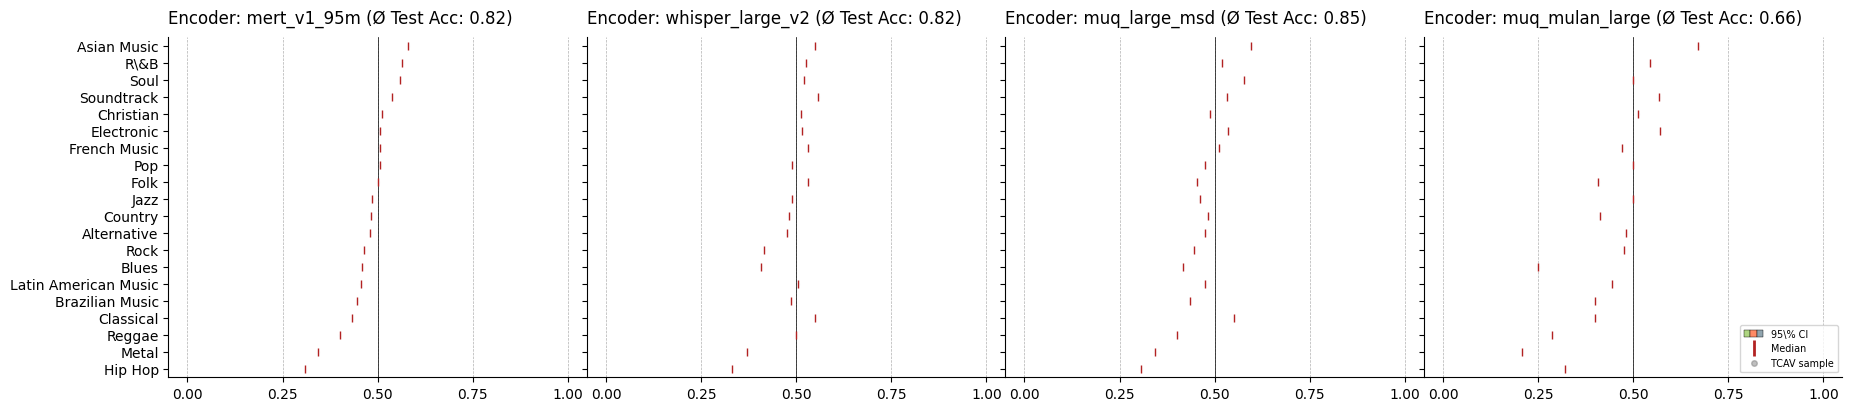

/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Evaluating gender_male with mert_v1_95m on genre
Evaluating gender_male with whisper_large_v2 on genre


FileNotFoundError: [Errno 2] No such file or directory: '../train_scripts/trainings/whisper_large_v2/gender_male/cav_full_bias_gender_male.npy'

In [ ]:
table_metrics = {}

for project_name in project_names:
    all_results = defaultdict(dict)

    for encoder_id in encoder_ids:
        print(f"Evaluating {project_name} with {encoder_id} on {target_column}")

        df_test = load_df_and_embeddings(
            project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
        )

        cav_vectors = get_cav_vectors(project_name, encoder_id, "ttest")
        cav_biases = get_cav_vectors(project_name, encoder_id, "bias_ttest")
        tcav_scores = calculate_tcav_scores(
            cav_vectors,
            cav_biases,
            df_test,
            target_column,
            embedding_prefix,
            encoder_id,
        )
        ttest_result = t_test_on_tcav_scores(tcav_scores, verbose=False)

        all_results[encoder_id]["tcav_scores"] = tcav_scores
        all_results[encoder_id]["ttest_results"] = ttest_result

        all_results[encoder_id]["metrics_ttest"] = get_train_evaluation_metrics(
            project_name, encoder_id, "ttest"
        )
        mean_test_acc = np.mean(
            [x["accuracy"] for x in all_results[encoder_id]["metrics_ttest"]]
        )
        all_results[encoder_id]["metrics_ttest_mean_acc"] = mean_test_acc
        all_results[encoder_id]["metrics_full"] = get_train_evaluation_metrics(
            project_name, encoder_id, "full"
        )

    file_name = os.path.join(
        "plots",
        f"tcav_ttest_{project_name}_{target_column}.png",
    )

    plot_tcav_scores(all_results, project_name, file_name, ci_boxplot=True)

    table_metrics[project_name] = all_results


In [ ]:
def format_table_models_with_metrics_columns(data):
    import re

    def escape_latex(s):
        if not isinstance(s, str):
            s = str(s)
        special_chars = {
            "&": r"\&",
            "%": r"\%",
            "$": r"\$",
            "#": r"\#",
            "_": r"\_",
            "{": r"\{",
            "}": r"\}",
            "~": r"\textasciitilde{}",
            "^": r"\textasciicircum{}",
            "\\": r"\textbackslash{}",
        }
        regex = re.compile("|".join(re.escape(key) for key in special_chars.keys()))
        return regex.sub(lambda match: special_chars[match.group()], s)

    models = list(data[project_names[0]].keys())

    metrics = {
        "Full Acc": ["metrics_full", "accuracy"],
        "Ø TTest Acc": ["metrics_ttest_mean_acc"],
    }

    # --- Header Rows ---
    header1 = ["\\textbf{}"] + [
        f"\\multicolumn{{{len(metrics)}}}{{c}}{{{escape_latex(m)}}}" for m in models
    ]
    header2 = [""] + [*metrics.keys()] * len(models)

    # --- Data Rows ---
    rows = []
    for pn in project_names:
        row = [project_name_display_map[pn]]
        for model in models:
            for metric_name in metrics:
                val = data[pn][model].copy()
                for locator in metrics[metric_name]:
                    val = val.get(locator)
                row.append(f"{val:.2f}")
        rows.append(row)

    num_cols = len(header2)
    col_format = "l" + " c" * (num_cols - 1)

    # --- LaTeX Table Code ---
    table = "\\begin{table}[ht]\n\\centering\n"
    table += "\\renewcommand{\\arraystretch}{1.}\n"
    table += "\\setlength{\\tabcolsep}{2pt} \n"
    table += "\\small\n"
    table += "\\begin{tabular}{" + col_format + "}\n"
    table += "\\toprule\n"
    table += " & ".join(header1) + " \\\\\n"
    table += " & ".join(header2) + " \\\\\n"
    table += "\\midrule\n"
    for row in rows:
        table += " & ".join(row) + " \\\\\n"
    table += "\\bottomrule\n"
    table += "\\end{tabular}\n"
    table += f"\\caption{{Some Caption}}\n"
    table += f"\\label{{some:label}}\n"
    table += "\\end{table}"

    # --- Full LaTeX Document ---
    document = (
        r"""\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\geometry{margin=1in}
\usepackage{booktabs}
\usepackage{multirow}
\title{Some Table}
\begin{document}
\maketitle
"""
        + "\n"
        + table
        + "\n"
        + r"\end{document}"
    )

    return document


In [10]:
get_cav_vectors(project_name, encoder_id, "full")


array([[-6.98260069e-01,  4.17120606e-01, -1.46565592e+00,
        -1.36730111e+00,  1.02232194e+00,  7.27741420e-01,
        -7.49982595e-01, -2.98624814e-01,  1.17824957e-01,
         9.39273179e-01, -2.29676843e-01, -1.94017959e+00,
         1.10180819e+00,  6.41785264e-01,  1.42242417e-01,
        -6.17870629e-01,  1.06376338e+00,  1.34970081e+00,
         9.81194139e-01, -4.78453159e-01,  7.32281864e-01,
        -8.86956275e-01,  9.39622462e-01, -8.85164499e-01,
         1.55435467e+00,  7.95649230e-01, -8.57039914e-03,
         1.29888028e-01, -6.37120614e-03,  5.05344942e-02,
         1.56355679e+00, -1.30107355e+00, -1.70278132e+00,
         1.09025681e+00, -4.43332016e-01, -5.38958669e-01,
        -1.30736232e-01, -4.75681107e-03, -7.56425932e-02,
        -1.76741388e-02, -1.11335015e+00, -5.06111979e-01,
         2.21037984e-01, -1.57276094e-01, -1.03142171e-03,
         7.83672929e-01,  1.16810882e+00, -5.42114437e-01,
        -6.73787117e-01, -3.98378879e-01, -1.65675604e+0

In [ ]:
data = table_metrics

open("latex.tex", "w").write(format_table_models_with_metrics_columns(data))


1395

In [ ]:
!pdflatex latex.tex 

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./latex.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/booktabs/booktabs.sty)
(/usr/share/texlive/texmf-dist/tex/latex/multirow/multirow.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-pdftex.def)
(./latex.aux)
*geometry* driver: auto-detecting
*geometry* detecte

### Captum Test


In [ ]:
from captum.concept import Concept, TCAV

from cavmir.training.network import CAVNetwork
from cavmir.utils import create_in_memory_dataloader
import torch

for project_name in project_names:
    encoder_id = "muq_mulan_large"

    cav = get_cav_vectors(project_name, encoder_id, "full")

    model = CAVNetwork(
        input_shape=512,
        target_shape=1,
        dropout_rate=0,
    )
    model.set_concept_activation_vector(cav)

    df_test = load_df_and_embeddings(
        project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
    )

    female_data = df_test[df_test["target"] == 1]
    non_female_data = df_test[df_test["target"] == 0]

    female_data_iter = create_in_memory_dataloader(female_data, embedding_only=True)
    non_female_data_iter = create_in_memory_dataloader(
        non_female_data, embedding_only=True
    )

    # Define the concepts
    female = Concept(1, "female", female_data_iter)
    non_female = Concept(0, "non_female", non_female_data_iter)

    mytcav = TCAV(model=model, layers=["linear"])

    cavs = mytcav.compute_cavs([[female, non_female]])

    # scores = mytcav.interpret(torch.Tensor(np.random.normal(size=(1,512))), [[female, non_female]], target=0)


/Users/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [ ]:
cavs["1-0"]["linear"].save()


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'assemble_save_path',
 'concepts',
 'create_cav_dir_if_missing',
 'layer',
 'load',
 'model_id',
 'save',
 'save_path',
 'stats']